# Cross-validation in backtesting

#### by Gustavo Soares

In this notebook you will apply a few things you learned in the [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures) as well as in the [FinanceHub's Quantitative Finance Lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Quantitative%20Finance%20Lectures). In particular, we will take a new look, under the cross-validation framework, at the dicussion we had on creating a signal for [time series strategies](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_strategies_intro.ipynb)


## Introduction

We often try different investment strategies in a particular financial dataset. After playing with the data for a while, we bound to find a particular investment strategy with good performance on that particular data. However, will that investment strategy perform out-of-sample? Unfortunately, we have no way of knowing it. Cross-validation consists on a technique to address that issue.

Cross-validation refers to a class of methods that estimate the performance of an investment strategy by holding out a subset of the training observations in the original dataset from the research process, and then applying the strategy to those held out observations. Let's get some data and start discussing different approaches for doing that.

## Getting started

Let's get the same signal and tracker data for currencies we discussed in our [time series strategies](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_strategies_intro.ipynb) notebook.

Our data consists in signals in FX trading:
[carry](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/carry.ipynb), [momentum](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/time_series_momentum.ipynb) and [value](https://github.com/Finance-Hub/FinanceHubMaterials/blob/master/Quantitative%20Finance%20Lectures/ppp_value_in_fx.ipynb). For each signal $s$ for $s \in \{carry,momentum,value\}$ we have a value $x_{s,i,t}$ containing the signal $s$ for currency $i$ at time $t$ already appropriately lagged. Remember, that we need to make sure $x_{s,i,t}$ is only using information that was available at the time of trading to predict h-period returns from time $t$ to some time in the future $t+h$. So, the value $x_{s,i,t}$ needs to be calculated using information prior to $t$. Here, we lag the information set by one period and calculate $x_{s,i,t}$ only with information contained in $\mathscr{I}_{t-1}$.

The variable we want to predict is
$$
r_{i,t+h} \equiv \frac{I_{t+h}}{I_{t}}-1
$$

which contains the returns of currency $i$ over the period between $t$ and $t+h$ as measured by the percentage change in the the currency tracker level $I_{t}$ over the period. This assumes that we traded at level $I_{t}$ at inception and closed the position $I_{t+h}$.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

# get the signal data
carry_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='carry',index_col=0)
print('carry data has %s currencies and %s dates' % (carry_df.shape[1],carry_df.shape[0]))
mom_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='momentum',index_col=0)
print('momentum data has %s currencies and %s dates' % (mom_df.shape[1],mom_df.shape[0]))
value_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='value',index_col=0)
print('value data has %s currencies and %s dates' % (value_df.shape[1],value_df.shape[0]))

# get the tracker data
trackers_df = pd.read_excel(r'fx_trackers_and_signals.xlsx',sheet_name='trackers',index_col=0)
print('trackers data has %s currencies and %s dates' % (trackers_df.shape[1],trackers_df.shape[0]))

# calculate future returns data
h = 21
# note the use of the .shift(-h) method below to make sure that on the index t we have the returns from t to t+h
returns_df = trackers_df.pct_change(h).shift(-h).dropna()
print('returns data has %s currencies and %s dates' % (returns_df.shape[1],returns_df.shape[0]))

carry data has 24 currencies and 4973 dates
momentum data has 24 currencies and 4968 dates
value data has 24 currencies and 4973 dates
trackers data has 24 currencies and 5220 dates
returns data has 24 currencies and 2241 dates


## Combining signals

Now, let's say I want to use at the classification technique discussed in Chapter 4 of [James, Witten, Hastie, and Tibshirani (2013)](http://faculty.marshall.usc.edu/gareth-james/ISL/). For example, let's say we want to use the logistic regression model:

$$
Prob(r_{i,t+h} \geqslant 0 | X_{i,t}) = \frac{e^{\gamma + \beta´X_{i,t}}}{1+e^{\gamma + \beta´X_{i,t}}}
$$

where $X_{i,t} = [x_{carry,i,t},x_{value,i,t}]'$ is a $2 \times 1$ vector of signals containing the signals for currency $i$ at time $t$ to combine the three signals contained in $X_{i,t}$ in order to predict the future returns $r_{i,t+h}$. Note that here we are using the same estimates of $\gamma$ and $\beta$ for all currencies.

In [2]:
import statsmodels.api as sm
pooled_data = pd.DataFrame()
for ccy in returns_df.columns:
    # get future returns
    y = 1*(np.sign(returns_df[ccy].to_frame('returns'))>0)
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_value = value_df[ccy].dropna().to_frame('value')
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    
    # let's normalize the variables to all have std = 1
    Z = (X/(X.ewm(halflife=63).std()).shift(1))
    
    # add constant to regression
    X = sm.add_constant(Z)
        
    # make sure the dates of the signals and future returns line up
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    pooled_data = pooled_data.append(yX)

model = sm.Logit(pooled_data.iloc[:,0], pooled_data.iloc[:,1:]).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.691674
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                returns   No. Observations:                53536
Model:                          Logit   Df Residuals:                    53533
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Apr 2020   Pseudo R-squ.:                0.001825
Time:                        11:14:15   Log-Likelihood:                -37029.
converged:                       True   LL-Null:                       -37097.
Covariance Type:            nonrobust   LLR p-value:                 3.983e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1041      0.010    -10.131      0.000      -0.124      -0.084
carry          0.0133      0.

This logistic regression suggests that we could combine the carry and value signal as

$$
s_{i,t} = sign\Big(\frac{e^{\hat{\gamma} + \hat{\beta}´Z_{i,t}}}{1+e^{\hat{\gamma} + \hat{\beta}´Z_{i,t}}} - 0.5\Big)
$$

for $\hat{\gamma} = -0.1041$ and $\hat{\beta}'=[0.0133,0.0015]'$. It's true that these two estimates use information of the full sample but since we are estimating only two parameters with 53536 observations, maybe that's ok. 

In [3]:
signal = pd.Series(index=pooled_data.index,data=np.sign(model.predict()-0.5))
pooled_data['returns'] = 1*(pooled_data['returns']==1) + -1*(pooled_data['returns']==0) # change bear signals from 0 to -1

Now, let's calculate the hit ratio, i.e., how many times this signal correctly predicts future bull and bear markets:

In [4]:
hit_ratio_in_sample = (1*(signal==pooled_data['returns'])).mean()
print('The hit ratio in-sample is: %s' % hit_ratio_in_sample)

The hit ratio in-sample is: 0.5131313508667065


So, we can see that this model, even using full sample data has a hit ratio only slighly higher than a coin flip. Do you think this will be the hit ratio out-of-sample? Let's start using some cross-validation to see that.

## Validation set

Estimating/calibrating/learning the parameters of an investment strategy and testing it on the same data is a methodological mistake. To avoid it, it is common practice to hold out part of the available data as a *test set* and *validation set*. There are two common approaches for splitting the data in finance: (i) split over time and (ii) split over markets.

#### Split over time

A common approach is to divide the set of observations into two parts, a training set and a *validation set* or *hold-out set*. The most basic approach in finance is to separate the dataset by time. For example, we could estimate our model on the first half of the data and then see the hit ratio on the second part of the data like this:

In [5]:
cut_off_date = pooled_data.index[int((max(pooled_data.index) - min(pooled_data.index)).days/2)]
train_set = pooled_data[pooled_data.index<=cut_off_date]
train_model = sm.Logit(1*(train_set.iloc[:,0]>0), train_set.iloc[:,1:]).fit()
print(train_model.summary())

Optimization terminated successfully.
         Current function value: 0.692827
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                returns   No. Observations:                39688
Model:                          Logit   Df Residuals:                    39685
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Apr 2020   Pseudo R-squ.:               0.0003765
Time:                        11:14:16   Log-Likelihood:                -27497.
converged:                       True   LL-Null:                       -27507.
Covariance Type:            nonrobust   LLR p-value:                 3.181e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.013      0.425      0.671      -0.020       0.031
carry          0.0006      0.

In [6]:
train_signal = np.sign(model.predict(train_set.iloc[:,1:])-0.5)
hit_ratio_in_sample = (1*(train_signal==train_set['returns'])).mean()
print('The hit ratio in-sample is: %s' % hit_ratio_in_sample)

validation_set = pooled_data[pooled_data.index>cut_off_date]
validation_signal = np.sign(model.predict(validation_set.iloc[:,1:])-0.5)
hit_ratio_out_sample = (1*(validation_signal==validation_set['returns'])).mean()
print('The hit ratio out-of-sample is: %s' % hit_ratio_out_sample)

The hit ratio in-sample is: 0.49455754888127396
The hit ratio out-of-sample is: 0.5663633737723859


This is a rare case where the out-of-sample hit ratio is actually better than the in-sample hit ratio. Note that we could have done it the other way around. We have chosen the more recent period as the training set and the period at the start of the sample as the validation set. See if you can do that as an exercise.

#### Split over markets

Another commoon alternative is to check on performance across different markets. It involves randomly dividing the available set of observation set approach two separate sets of markets. Let's see how to do that:

In [7]:
train_cccy = ['AUD', 'BRL', 'CAD', 'CHF', 'CLP', 'CNH', 'COP', 'CZK','PLN', 'GBP','HUF', 'IDR']
validation_ccy = ['ILS', 'INR', 'JPY', 'KRW', 'MXN', 'NOK', 'NZD', 'EUR', 'RUB', 'SEK', 'TRY', 'ZAR']
train_data = pd.DataFrame()
validation_data = pd.DataFrame()
for ccy in returns_df.columns:
    # get future returns
    y = 1*(np.sign(returns_df[ccy].to_frame('returns'))>0)
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_value = value_df[ccy].dropna().to_frame('value')
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    
    # let's normalize the variables to all have std = 1
    Z = (X/(X.ewm(halflife=63).std()).shift(1))
    
    # add constant to regression
    X = sm.add_constant(Z)
        
    # make sure the dates of the signals and future returns line up
    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    
    if ccy in train_cccy:
        train_data = train_data.append(yX)
    else:
        validation_data = validation_data.append(yX)

model = sm.Logit(train_data.iloc[:,0], train_data.iloc[:,1:]).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.692331
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                returns   No. Observations:                26644
Model:                          Logit   Df Residuals:                    26641
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Apr 2020   Pseudo R-squ.:               0.0007742
Time:                        11:14:16   Log-Likelihood:                -18446.
converged:                       True   LL-Null:                       -18461.
Covariance Type:            nonrobust   LLR p-value:                 6.204e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0862      0.014     -6.026      0.000      -0.114      -0.058
carry          0.0098      0.

In [8]:
train_signal = np.sign(model.predict(train_data.iloc[:,1:])-0.5)
train_data['returns'] = 1*(train_data['returns']==1) + -1*(train_data['returns']==0) # change bear signals from 0 to -1
hit_ratio_in_sample = (1*(train_signal==train_data['returns'])).mean()
print('The hit ratio in-sample is: %s' % hit_ratio_in_sample)

validation_signal = np.sign(model.predict(validation_data.iloc[:,1:])-0.5)
validation_data['returns'] = 1*(validation_data['returns']==1) + -1*(validation_data['returns']==0) # change bear signals from 0 to -1
hit_ratio_out_sample = (1*(validation_signal==validation_data['returns'])).mean()
print('The hit ratio out-of-sample is: %s' % hit_ratio_out_sample)

The hit ratio in-sample is: 0.5083696141720463
The hit ratio out-of-sample is: 0.512085378551242


#### Random split

In [scikit-learn cross validation package](https://scikit-learn.org/stable/modules/cross_validation.html) one can easily randomly split the data into training and test sets can be quickly computed with the train_test_split helper function. Let’s see how to do that in our data. Below we use the *test size* parameter to hold out 30% of the data for testing (evaluating) our signal:

In [9]:
from sklearn.model_selection import train_test_split
X = pooled_data.iloc[:,1:]
y = pooled_data.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = sm.Logit(1*(np.sign(y_train)>0), X_train).fit()
print(model.summary())

train_signal = np.sign(model.predict(X_train)-0.5)
hit_ratio_in_sample = (1*(train_signal==y_train)).mean()
print('The hit ratio in-sample is: %s' % hit_ratio_in_sample)

validation_signal = np.sign(model.predict(X_test)-0.5)
hit_ratio_out_sample = (1*(validation_signal==y_test)).mean()
print('The hit ratio out-of-sample is: %s' % hit_ratio_out_sample)

Optimization terminated successfully.
         Current function value: 0.691430
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                returns   No. Observations:                37475
Model:                          Logit   Df Residuals:                    37472
Method:                           MLE   Df Model:                            2
Date:                Sun, 05 Apr 2020   Pseudo R-squ.:                0.002160
Time:                        11:14:16   Log-Likelihood:                -25911.
converged:                       True   LL-Null:                       -25967.
Covariance Type:            nonrobust   LLR p-value:                 4.364e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1119      0.012     -9.067      0.000      -0.136      -0.088
carry          0.0143      0.

It is important to be careful when using the [scikit-learn cross validation package](https://scikit-learn.org/stable/modules/cross_validation.html) as the random split between training and test sets implicitly assume that the underlying data is IID. Nonetheless, depend on the context, random split between training and test sets can be useful even in the time series context. Perhaps, the most important recommendation is to try different things to see if results are robust.

## Leave one out

Leave-one-out cross-validation (LOOCV) also splitting the set of observations into two parts. Each learning set is created by taking all the samples except one, the test set being the sample left out. This cross-validation procedure does not waste much data as only one sample is removed from the training set. However, instead of creating two subsets of comparable size, a single observation, a date or a currency, is used as the validation set, and the remaining observations make up the training set. The signal is fit on the training observations and a prediction is made for the excluded observation.

After the entire process, we will have trained $N$ models, as many models as there are observations. We will have a set of parameters $\theta_{1},\dots,\theta_{N}$, one for each observation $k$. If we are interested in a function of those parameters $T(\theta)$, such as the hit ratio for example, the cross-validation estimate for that number will be:

$$
T_{CV}(\theta) = N^{-1}\sum_{k=1}^{N}T(\theta_{k})
$$


#### Leave one date out

In the time series context, we can use LOOCV to exclude one particular date. Let's take one particular currency to see how that works using [scikit-learn cross validation package](https://scikit-learn.org/stable/modules/cross_validation.html):

In [10]:
ccy='BRL'
train_data = pd.DataFrame()
validation_data = pd.DataFrame()
y = 1*(np.sign(returns_df[ccy].to_frame('returns'))>0)
X_carry = carry_df[ccy].dropna().to_frame('carry')
X_value = value_df[ccy].dropna().to_frame('value')
# make sure the signals are lined up and fill the nan's with the last obs in case there are some
X = pd.concat([X_carry,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
# let's normalize the variables to all have std = 1
Z = (X/(X.ewm(halflife=63).std()).shift(1))
# add constant to regression
X = sm.add_constant(Z)
# make sure the dates of the signals and future returns line up
yX = pd.concat([y,X],axis=1,sort=True).dropna()

Now that we have the time series data for that currency, let's apply the LOOCV methodology for estimating the hit ratio:

In [11]:
from sklearn.model_selection import LeaveOneOut
hit_ratio_out_sample = pd.Series()
loo = LeaveOneOut()
for train, test in loo.split(yX):
    model = sm.Logit(1*(np.sign(yX.iloc[train,0])>0), yX.iloc[train,1:]).fit(disp=False)
    validation_signal = 1*(np.sign(model.predict(yX.iloc[test,1:])-0.5)>0)
    hit_ratio_out_sample = hit_ratio_out_sample.append(1*(validation_signal==yX.iloc[test,0]))
hit_ratio_out_sample.mean()

C:\Users\Gustavo\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


0.5671575189647479

#### Leave one market out

Alternatively, we can use LOOCV to exclude one particular market. Let's how that works using [scikit-learn cross validation package](https://scikit-learn.org/stable/modules/cross_validation.html):

In [12]:
group_dict = dict(zip([ccy for ccy in returns_df.columns],range(len(returns_df.columns))))
pooled_data = pd.DataFrame()
groups = pd.DataFrame()
for ccy in returns_df.columns:
    # get future returns
    y = 1*(np.sign(returns_df[ccy].to_frame('returns'))>0)
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_value = value_df[ccy].dropna().to_frame('value')
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    
    # let's normalize the variables to all have std = 1
    Z = (X/(X.ewm(halflife=63).std()).shift(1))    
    X = sm.add_constant(Z)        

    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    
    group = pd.DataFrame(index=yX.index,columns=['group'],data=group_dict[ccy])
    
    
    pooled_data = pooled_data.append(yX)
    groups = groups.append(group)

Now let's run the leave One Group Out cross-validator to estimate the signals hit ratio:

In [14]:
from sklearn.model_selection import LeaveOneGroupOut
X = pooled_data.iloc[:,1:]
y = pooled_data.iloc[:,0]
logo = LeaveOneGroupOut()
logo.get_n_splits(groups=groups)
hit_ratio_out_sample = pd.Series()
for train_index, test_index in logo.split(X, y, groups.iloc[:,0]):
    model = sm.Logit(1*(np.sign(y.iloc[train_index])>0), X.iloc[train_index]).fit(disp=False)
    validation_signal = 1*(np.sign(model.predict(X.iloc[test_index])-0.5)>0)
    hit_ratio_out_sample = hit_ratio_out_sample.append(1*(validation_signal==y.iloc[test_index]))
hit_ratio_out_sample.mean()   

C:\Users\Gustavo\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


0.5128698445905558

## K-Fold Cross-Validation

K-fold cross validation is another cross-validation technique that makes strong use of the assumption of the data being IID. This technique needs to be used carefully when dealing with financial time series. Let's see how it works.

K-fold divides all the samples in  groups of samples, called folds (if , this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using  folds, and the fold left out is used for test. The image below says it all:

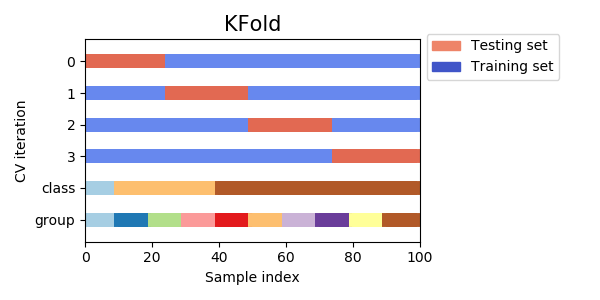

Check out the function KFold and GroupKFold in  [scikit-learn cross validation package](https://scikit-learn.org/stable/modules/cross_validation.html) for more information but the idea is very similar to LOOCV.

## Cross validation of time series data with time series split

For time series data, we need to use a variation of k-fold which returns first $k$ folds as train set and the $k+1$ fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Let's look at the picture:


In [15]:
from sklearn.model_selection import TimeSeriesSplit
ccy='BRL'
train_data = pd.DataFrame()
validation_data = pd.DataFrame()
y = 1*(np.sign(returns_df[ccy].to_frame('returns'))>0)
X_carry = carry_df[ccy].dropna().to_frame('carry')
X_value = value_df[ccy].dropna().to_frame('value')
# make sure the signals are lined up and fill the nan's with the last obs in case there are some
X = pd.concat([X_carry,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
# let's normalize the variables to all have std = 1
Z = (X/(X.ewm(halflife=63).std()).shift(1))
# add constant to regression
X = sm.add_constant(Z)
# make sure the dates of the signals and future returns line up
yX = pd.concat([y,X],axis=1,sort=True).dropna()
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(yX):
    model = sm.Logit(1*(np.sign(yX.iloc[train,0])>0), yX.iloc[train,1:]).fit(disp=False)
    validation_signal = 1*(np.sign(model.predict(yX.iloc[test,1:])-0.5)>0)
    hit_ratio_out_sample = hit_ratio_out_sample.append(1*(validation_signal==yX.iloc[test,0]))
hit_ratio_out_sample.mean()

0.5107396406838598

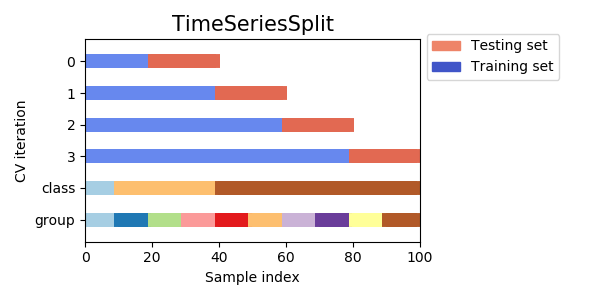

## Cross-validation for parameter learning

After the entire cross process, we will have trained $K$ models, one for each fold, and we will have a set of parameters $\theta_{1},\dots,\theta_{K}$, one for each fold $k$. If we are interested in a function of those parameters $T(\theta)$, such as the hit ratio for example, the cross-validation estimate for that number will be:

$$
T_{CV}(\theta) = K^{-1}\sum_{k=1}^{K}T(\theta_{k})
$$

However, we can also use the function $T_{CV}(\theta)$ to weight the different parameters to come up with a cross-validation weighted parameter average such as:

$$
\hat{\theta} = \frac{\sum_{k=1}^{K}T(\theta_{k} ) \times  \theta_{k}}{\sum_{k=1}^{K}T(\theta_{k})}
$$

Let's try that in our leave one market out approach:

In [16]:
group_dict = dict(zip([ccy for ccy in returns_df.columns],range(len(returns_df.columns))))
pooled_data = pd.DataFrame()
groups = pd.DataFrame()
for ccy in returns_df.columns:
    # get future returns
    y = 1*(np.sign(returns_df[ccy].to_frame('returns'))>0)
    # get the three signals
    X_carry = carry_df[ccy].dropna().to_frame('carry')
    X_value = value_df[ccy].dropna().to_frame('value')
    # make sure the signals are lined up and fill the nan's with the last obs in case there are some
    X = pd.concat([X_carry,X_value],join='outer',axis=1,sort=True).fillna(method='ffill').dropna()
    
    # let's normalize the variables to all have std = 1
    Z = (X/(X.ewm(halflife=63).std()).shift(1))    
    X = sm.add_constant(Z)        

    yX = pd.concat([y,X],axis=1,sort=True).dropna()
    
    group = pd.DataFrame(index=yX.index,columns=['group'],data=group_dict[ccy])
    
    
    pooled_data = pooled_data.append(yX)
    groups = groups.append(group)

X = pooled_data.iloc[:,1:]
y = pooled_data.iloc[:,0]
logo.get_n_splits(groups=groups)
parameters_df = pd.DataFrame()
i = 0
for train_index, test_index in logo.split(X, y, groups.iloc[:,0]):
    i += 1
    model = sm.Logit(1*(np.sign(y.iloc[train_index])>0), X.iloc[train_index]).fit(disp=False)
    params = model.params
    validation_signal = 1*(np.sign(model.predict(X.iloc[test_index])-0.5)>0)
    params['hit_ratio'] = (1*(validation_signal==y.iloc[test_index])).mean()
    parameters_df = parameters_df.append(params.to_frame(i).T)
    
parameters_df

,const,carry,value,hit_ratio
1,-0.095545,0.013759,0.001301,0.551093
2,-0.098554,0.012203,0.001551,0.571620
3,-0.103020,0.015709,0.001280,0.495761
4,-0.111472,0.013782,0.001542,0.517626
5,-0.101912,0.013159,0.001504,0.526997
6,-0.143982,0.012030,0.004430,0.537883
7,-0.102269,0.013871,0.001455,0.481481
8,-0.098502,0.012558,0.001545,0.545739
9,-0.093958,0.011920,0.001469,0.563588
10,-0.105414,0.013516,0.001479,0.475234


Because we left one market out in each fold, we have 24 models with 24 set of parameters and associated with each one of them a hit ratio out-of-sample calculated by the currency held out in that particular fold. Our cross-validated parameter estimates then are:

In [17]:
cv_param = ((parameters_df.iloc[:,:-1]).multiply(parameters_df.iloc[:,-1],axis=0)).sum()/((parameters_df.iloc[:,-1]).sum())
cv_param

const   -0.104419
carry    0.013193
value    0.001577
dtype: float64